## MCMC sampling with the convergence monitoring

The ln(target distribution) is the Rosenbrock function.

### set-up for the sampling        

In [3]:
from glob import glob
from multiprocessing import Pool
from os import mkdir, remove, stat
from os.path import basename, isdir, isfile
from shutil import copyfile

from corner import corner
from emcee import EnsembleSampler
from emcee.autocorr import integrated_time
from emcee.backends import HDFBackend
from emcee.moves import StretchMove
from matplotlib import rc, rcParams
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.pyplot import subplots
from matplotlib.transforms import Bbox
from numpy import arange, concatenate, empty, exp, genfromtxt, linspace, log, mean, ndarray, sort, where
from scipy.optimize import Bounds, differential_evolution

from metallicity_mcmc import mcmc_sampling, plot_chains

# -- font size
rcParams['font.size']=13

# -- output directory
dir = 'MCMC_sampling/'
if not isdir(dir):
    print('### Create a directory ... : ' + dir)
    mkdir(dir)
mcmc_pass_kwargs = {'glopt': False}

# -- results from the global optimization (finding the mode of the target distribution)
glopt_file = dir+'Rosenbrock.glopt'

def ln_target(param, glopt=True):
    Rosenbrock=-(100*(param[1]-param[0]**2)**2 + (1-param[0])**2)/20.
    ret_val = Rosenbrock if not glopt else -Rosenbrock
    return ret_val


### find the best-fit parameters using a global optimization method (differential evolution)

- The tolerance is deliberately loosened to 0.9 so that the results distribute *around* the global minimum (1,1) not to fall exactly on it. You may need to reduce the tolerance for your task, say 0.01.

- The results are used as the initial positions for the MCMC sampling [see S1) below].

In [4]:
def find_bestfitpar(output_num, out_glopt):
    #  a reasonable choice for NP is between 5*D and 10*D (Storn_1997_J.GlobalOptim._11_341)
    print('### number of output is {} ...'.format(output_num))
    print('### Save... ' + out_glopt)
    f_glopt = open(out_glopt, 'w')
    
    lb=[-10,-5]        
    ub=[10,50]        

    for i in range(output_num):
        glopt = differential_evolution(ln_target, Bounds(lb, ub), workers=-1, tol=0.9)
        if glopt.success:
            prtstr = ' |'.join(['{:>15.8e}'.format(i) for i in glopt.x])
            print(prtstr)
            f_glopt.write(prtstr + '\n')
    print('### Done...')
    f_glopt.close()

output_num = 32     # This is equal to the number of walkers for the MCMC sampling.
find_bestfitpar(output_num, glopt_file)

### number of output is 32 ...
### Save... MCMC_sampling/Rosenbrock.glopt
 9.99999545e-01 | 9.99999195e-01
 1.00000313e+00 | 1.00000633e+00
 9.99995813e-01 | 9.99991675e-01
 9.99993719e-01 | 9.99987167e-01
 9.99998718e-01 | 9.99997378e-01
 1.00000616e+00 | 1.00001229e+00
 1.00016225e+00 | 1.00032519e+00
 9.99912830e-01 | 9.99825333e-01
 9.99996316e-01 | 9.99992460e-01
 9.99903025e-01 | 9.99805675e-01
 1.00034812e+00 | 1.00069802e+00
 1.00022700e+00 | 1.00045497e+00
 9.99979432e-01 | 9.99958866e-01
 9.99996910e-01 | 9.99993814e-01
 9.99999998e-01 | 9.99999995e-01
 9.99987742e-01 | 9.99975446e-01
 9.99853921e-01 | 9.99707268e-01
 9.99997069e-01 | 9.99994779e-01
 9.99996840e-01 | 9.99993676e-01
 9.99997060e-01 | 9.99994114e-01
 1.00000000e+00 | 1.00000000e+00
 1.00017834e+00 | 1.00035745e+00
 1.00036206e+00 | 1.00072567e+00
 9.99998780e-01 | 9.99997754e-01
 9.99915948e-01 | 9.99831496e-01
 9.99905578e-01 | 9.99810795e-01
 9.99987166e-01 | 9.99973800e-01
 9.99994191e-01 | 9.99988700e-01
 9

/home/jhshinn/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:461: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


### plot the best-fit parameters

### Read... MCMC_sampling/Rosenbrock.glopt
### Save... MCMC_sampling/Rosenbrock.bestfitpar.png


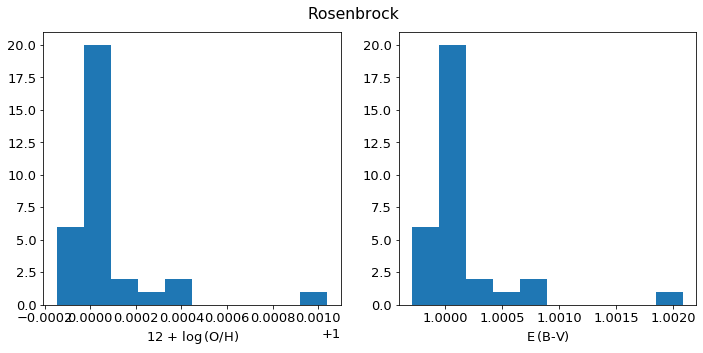

In [5]:
def plot_bestfitpar(glopt_file):
    col0 = genfromtxt(glopt_file, delimiter='|', names=['metal', 'E_BV'])
    fig, ax = subplots(1, 2, figsize=(10,5))
    ax[0].hist(col0['metal'])
    ax[0].set_xlabel('12 + log$\,$(O/H)')
    ax[1].hist(col0['E_BV'])
    ax[1].set_xlabel('E$\,$(B-V)')
    outfile = glopt_file.replace('.glopt','.bestfitpar.png')
    print('### Save... ' + outfile)
    suptitle = basename(glopt_file.replace('.glopt',''))
    fig.suptitle(suptitle)
    fig.tight_layout(rect=[0,0,1,0.95])
    fig.savefig(outfile)

glopt_files=sort(glob(dir+'*.glopt'))
for glopt_file in glopt_files:
    print('### Read... {}'.format(glopt_file))
    plot_bestfitpar(glopt_file)

---

### Note
- MCMC sampling with convergence monitoring needs some try-and-error.
To get the proper samples, the sequence below should be repeated to some extent, like S1-S2-S3-S2-S3-...-S2-S4.
  

### S1) run the MCMC sampling for the --first time-- & make a backup backend & plot the chains to see the burn-in process

MCMC_sampling/Rosenbrock.h5
### Delete the existing backend file and create a new one...
### Save backend file... : MCMC_sampling/Rosenbrock.h5
### Total iteration: 2000
### Save ... MCMC_sampling/Rosenbrock.last_coords.dat
### Copy the backend file to the backup : MCMC_sampling/Rosenbrock.backup.h5
### (iter, nwalkers, ndim) = (2000, 32, 2)
### Save... MCMC_sampling/Rosenbrock.plot_chains.png


/home/jhshinn/anaconda3/envs/idp/lib/python3.6/site-packages/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|██████████| 2000/2000 [00:14<00:00, 136.26it/s]


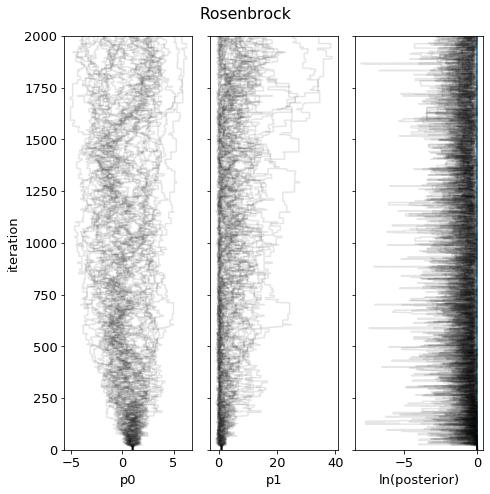

In [7]:
def plot_chains(backend_file, truths=None, set_ymm=None):
    # -- extract chains from backend
    reader = HDFBackend(backend_file)
    chain: ndarray = reader.get_chain()
    iteration, nwalkers, ndim = chain.shape
    print('### (iter, nwalkers, ndim) = {}'.format(chain.shape))
    chain_log_prob: ndarray = reader.get_log_prob()
    # -- chain plots
    outfile0 = backend_file.replace('.h5', '.plot_chains.png')
    title = basename(backend_file.replace('.h5', ''))
    fig, axes = subplots(1, 3, figsize=(7, 7), sharey=True)
    fig.suptitle(title)
    labels = ['p0', 'p1', 'ln(posterior)']
    for i in range(ndim + 1):
        ax: Axes = axes[i]
        if i == ndim:
            ax.set_xlabel(labels[i])
            ax.axvline(x=max(chain_log_prob[0, :]))
            ax.plot(chain_log_prob, arange(iteration), "k", alpha=0.1)
        else:
            ax.plot(chain[:, :, i], arange(iteration), "k", alpha=0.1)
            if truths: ax.axvline(truths[i], color='red')
            ax.set_xlabel(labels[i])
        ax.set_ylim(0, len(chain))
    axes[0].set_ylabel("iteration");
    if set_ymm: axes[0].set_ylim(set_ymm)
    print('### Save... ' + outfile0)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(outfile0)

def mcmc_sampling(backend_file, backend_reset, glopt_file, iteration, mcmc_pass_kwargs, random_state=None, stretch_a=2.):
    # -- result file
    backend = HDFBackend(backend_file)
    print('### Save backend file... : {}'.format(backend_file))
    # -- the initial values
    if backend_reset:
        init_values = genfromtxt(glopt_file, delimiter='|', dtype='f8')
        nwalkers, ndim = init_values.shape
    else:
        init_values = backend.get_last_sample()
        init_values.random_state = random_state
        nwalkers, ndim = backend.shape
    # -- backend reset
    if backend_reset: backend.reset(nwalkers, ndim)
    # -- multiprocessing
    with Pool() as pool:
        sampler = EnsembleSampler(nwalkers, ndim, ln_target, moves=StretchMove(a=stretch_a),
                                  kwargs=mcmc_pass_kwargs, pool=pool, backend=backend)
        sampler.run_mcmc(init_values, iteration, progress=True)
    print('### Total iteration: {}'.format(sampler.iteration))
    random_state = sampler.random_state
    # -- save last coords
    outfile = backend_file.replace('.h5', '.last_coords.dat')
    print('### Save ... ' + outfile)
    f_out = open(outfile, 'w')
    co_arr = backend.get_last_sample().coords
    row, col = co_arr.shape
    for row_i in range(row):
        prtstr = ' |'.join(['{:0f}'.format(i) for i in co_arr[row_i, :]])
        f_out.write(prtstr + '\n')
    f_out.close()
    return random_state

def sample_new():
    backend_reset = True
    random_state_last = mcmc_sampling(backend_file, backend_reset, glopt_file, iteration, mcmc_pass_kwargs)
    print('### Copy the backend file to the backup : {}'.format(backend_backup_file))
    copyfile(backend_file, backend_backup_file)
    plot_chains(backend_file)
    return random_state_last

iteration = 2000

# -- file setting
backend_file = glopt_file.replace('.glopt','.h5')
backend_backup_file = backend_file.replace('.h5','.backup.h5')

# -- backend existence check
if isfile(backend_file):
    print(backend_file)
    file_size_MB=stat(backend_file).st_size >> 20
    chk = input('file size = {} MB.'.format(file_size_MB)+' ### Delete it? (y or else) :')
    if chk == 'y':
        print('### Delete the existing backend file and create a new one...')
        remove(backend_file)
        random_state_last = sample_new()
    else:
        print('### backend_file is unchanged.')
        backend = HDFBackend(backend_file)
        random_state_last = backend.get_last_sample().random_state 
else: 
    random_state_last = sample_new()

### S2) plot corner & integrated autocorrelation time
When the convergence is good enough (e.g., each $\tau_{int}$ crosses the "ESS = 2000" line), go to S4) and check if there is any other local extrema. 

### (iter, nwalkers, ndim) = (20500, 32, 2)
### Save... MCMC_sampling/Rosenbrock_BurnIn1500.plot_corner.png
### (iter, nwalkers, ndim) = (500, 32, 2)
### Save... MCMC_sampling/Rosenbrock.backup_BurnIn1500.plot_corner.png


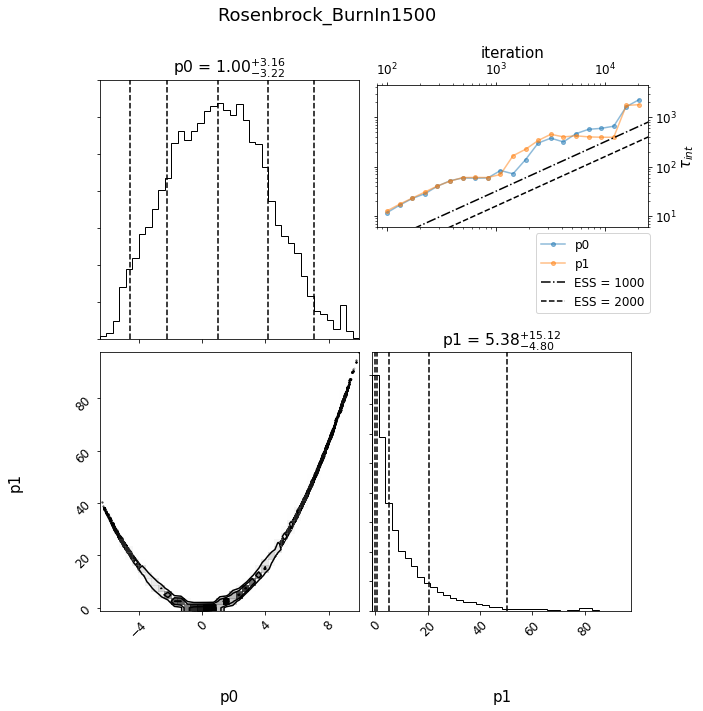

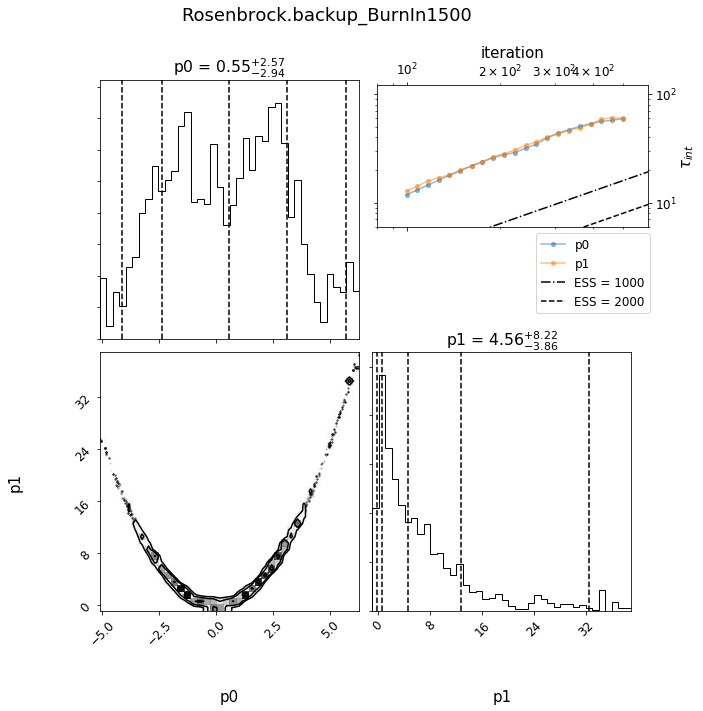

In [10]:
def plot_corner(backend_file, burn_in, truths=None, pdf=False, chain_end=None, quantiles=None):
    # -- extract chains from backend
    reader = HDFBackend(backend_file)
    chain: ndarray = reader.get_chain()
    if chain_end:
        chain = chain[burn_in:burn_in + chain_end, :, :]
    else:
        chain = chain[burn_in:, :, :]
    iteration, nwalkers, ndim = chain.shape
    print('### (iter, nwalkers, ndim) = {}'.format(chain.shape))
    
    # -- integrated autocorrelation time calculation
    chk_num = 21
    chain_mean = mean(chain, axis=1)
    iat_arr = empty((chk_num, ndim))
    chks = exp(linspace(log(100), log(iteration), chk_num)).astype(int)
    for chk in chks:
        chk_ind = where(chks == chk)[0]
        for dim in range(ndim):
            iat_arr[chk_ind, dim] = integrated_time(chain_mean[:chk, dim], tol=0)
    
    #---- plotting
    ## -- corner plots
    labels = ['p0', 'p1', 'ln(posterior)']
    burnin_tag = '_BurnIn{:04d}'.format(burn_in)
    outfile1 = backend_file.replace('.h5', burnin_tag + '.plot_corner.png')
    if pdf: outfile1 = outfile1.replace('.png', '.pdf')
    chain_rsh = chain.reshape([-1, ndim])
    title = basename(backend_file.replace('.h5', burnin_tag))
    ftsize = 15
    rc('axes', labelsize=ftsize)
    rc('xtick', labelsize=ftsize * 0.8)
    rc('ytick', labelsize=ftsize * 0.8)
    if not quantiles: quantiles = [0.025, 0.16, 0.5, 0.84, 0.975]
    fig: Figure = corner(chain_rsh, bins=40, truth_color='red', truths=truths, labels=labels[0:4],
                         quantiles=quantiles, show_titles=True)
    fig.suptitle(title, fontsize=ftsize * 1.2, y=1.03)
    ## -- tau_iat evolution as an overplot
    enlarge = 1.8
    f_w, f_h = fig.get_size_inches()
    fig.set_size_inches(f_w * enlarge, f_h * enlarge)
    ax0: Axes = fig.add_subplot(111)
    for par in range(ndim): ax0.plot(chks, iat_arr[:, par], '-o', markersize=4, label=labels[par], alpha=0.5)
    chks_ext = concatenate([[chks[0] / 2.], chks])
    chks_ext = concatenate([chks_ext, [chks[-1] * 2.]])
    ess_chk = 1000. / nwalkers
    ax0.plot(chks_ext, chks_ext / ess_chk, '-.k', label='ESS = 1000')
    ess_chk = 2000. / nwalkers
    ax0.plot(chks_ext, chks_ext / ess_chk, '--k', label='ESS = 2000')
    ax0.semilogx()
    ax0.semilogy()
    ax0.tick_params(which='both', top=True, right=True,
                    labelbottom=False, labelleft=False, labeltop=True, labelright=True)
    ax0.xaxis.set_label_position('top')
    ax0.yaxis.set_label_position('right')
    ax0.set_xlim(chks[0] * 0.8, chks[-1] * 1.2)
    ax0.set_ylim(iat_arr.min() * 0.5, iat_arr.max() * 2)
    ax0.set_xlabel('iteration')
    ax0.set_ylabel(r'$\tau_{int}$')
    ax0.legend(fontsize=ftsize * 0.8, loc='upper right', bbox_to_anchor=(1.03, 0))
    pos2 = [0.57, 0.72, 0.38, 0.20]
    ax0.set_position(pos2)
    
    # -- save
    print('### Save... ' + outfile1)
    f_enlarge = 1.05
    shift = -0.1
    bb = fig.bbox_inches.bounds
    bb_new = (bb[0] + shift, bb[1] + shift, bb[2] * f_enlarge, bb[3] * f_enlarge)
    fig.savefig(outfile1, bbox_inches=Bbox.from_bounds(*bb_new))

burn_in = 1500

plot_corner(backend_file, burn_in)
plot_corner(backend_backup_file, burn_in)

### S3) determine whether to accept the newly-added chains or not 

1. abandon = True or False, then run the script
2. go to S2) above, run there, and check the plot.

### Copy the backend to the backup...
### Save backend file... : MCMC_sampling/Rosenbrock.h5
### Total iteration: 22000
### Save ... MCMC_sampling/Rosenbrock.last_coords.dat
### (iter, nwalkers, ndim) = (22000, 32, 2)
### Save... MCMC_sampling/Rosenbrock.plot_chains.png


100%|██████████| 20000/20000 [02:30<00:00, 132.56it/s]


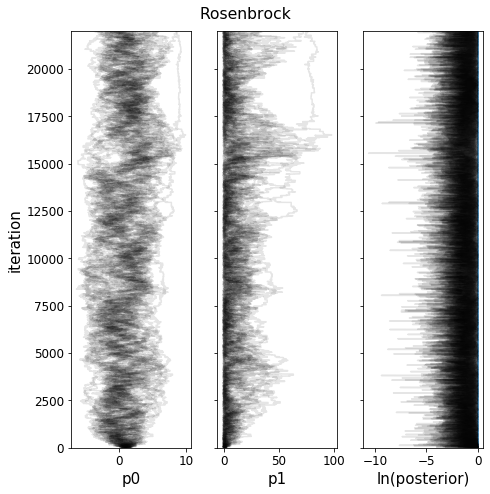

In [9]:
iteration = 20000
# -- choose one
# abandon = True
abandon = False

backend_reset = False   # Do not change this value
if abandon:
    copyfile(backend_backup_file, backend_file)
    print('### Copy the backup to the backend...')
else:
    copyfile(backend_file, backend_backup_file)
    print('### Copy the backend to the backup...')

random_state_last = mcmc_sampling(backend_file, backend_reset, glopt_file, iteration,
                                  mcmc_pass_kwargs, random_state=random_state_last)
plot_chains(backend_file)

### S4) search for local extrema with an increased stretch length.

### Save backend file... : MCMC_sampling/Rosenbrock.extsrch.h5
### Total iteration: 1000
### (iter, nwalkers, ndim) = (1000, 32, 2)
### Save... MCMC_sampling/Rosenbrock.extsrch.plot_chains.png


100%|██████████| 1000/1000 [00:07<00:00, 137.20it/s]


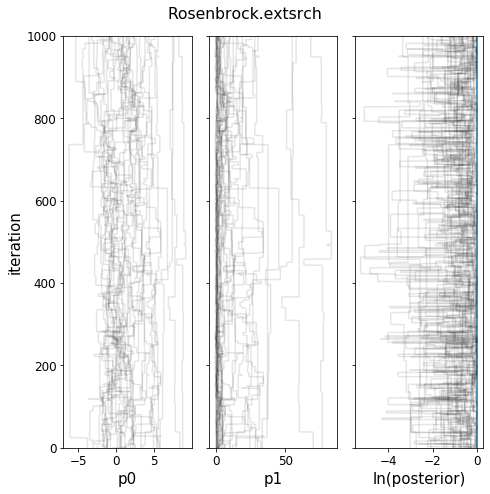

In [11]:
iteration = 1000
stretch_width = 2.*10

# -- sampler setting
lastco_file = backend_file.replace('.h5','.last_coords.dat')
init_values = genfromtxt(lastco_file, delimiter='|', dtype='f8')
nwalkers, ndim = init_values.shape
# -- backend setting
backend_extsrch_file = backend_file.replace('.h5','.extsrch.h5')
backend_extsrch = HDFBackend(backend_extsrch_file)
backend_extsrch.reset(nwalkers, ndim)
print('### Save backend file... : {}'.format(backend_extsrch_file))
# -- multiprocessing
with Pool() as pool:
    sampler = EnsembleSampler(nwalkers, ndim, ln_target, moves=StretchMove(a=stretch_width), kwargs=mcmc_pass_kwargs, pool=pool, backend=backend_extsrch)
    sampler.run_mcmc(init_values, iteration, progress=True)
print('### Total iteration: {}'.format(sampler.iteration))
plot_chains(backend_extsrch_file)

